### Capstone Project
This notebook is mainly used for the capstone project of the 'Applied Data Science' course.

###### installations

In [1]:
#set TEST to True if testing and data was already downloaded (Foresquare, Geolocator etc.)
TEST = True

In [2]:
# !{sys.executable} -m pip install pandas numpy
# !{sys.executable} -m pip install requests lxml
# !{sys.executable} -m pip install geopandas
# !{sys.executable} -m pip install geopy
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install folium
! pip install --user pandas numpy requests lxml geopandas geopy
! pip install --user sklearn yellowbrick folium

###### imports

In [3]:
import os
import geocoder
import requests
import pandas as pd
import numpy as np
import folium 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

### Data Loading And Cleaning 

In [4]:
address = 'Toronto, ON'
try:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
except:
    print("Could not use geolocator, using deafult values")
    latitude = 43.651070
    longitude = -79.347015
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


#### Crime Data

In [5]:
df_crime = pd.read_csv('MCI_2014_to_2018.csv')
df_crime.rename(columns={"Neighbourhood": "Neighborhood"}, inplace=True)
print("Crime dataset with %s crimes %d unique neighbourhoods." % df_crime.shape , len(df_crime['Neighborhood'].unique()))

# remove brackets and ID from Neighborhood column
df_crime['Neighborhood'] = df_crime.Neighborhood.str.split("(", expand=True)
# move neighborhood column to the first column
df_crime = df_crime[ ['Neighborhood'] + [ col for col in df_crime.columns if col != 'Neighborhood' ] ]

Crime dataset with 167525 crimes 29 unique neighbourhoods. 141


Total crimes per neighborhood

In [6]:
df_crime_total = df_crime.groupby('Neighborhood').count()[['MCI']]
df_crime_total.reset_index(drop=False, inplace=True)
df_crime_total.rename(columns={"MCI": "Total Crimes"}, inplace=True)
df_crime_total = df_crime_total.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_crime_total.head()

,Neighborhood,Total Crimes
0,Agincourt North,1008
1,Agincourt South-Malvern West,1331
2,Alderwood,460
3,Annex,2908
4,Banbury-Don Mills,938


#### Demographic Data 
load from https://open.toronto.ca/dataset/neighbourhood-profiles/

In [7]:
# df_demo = pd.read_csv('neighbourhood-profiles-2016.csv')
df_demo = pd.read_csv('neighbourhood-profiles-2016.csv', thousands=',')
df_demo.drop(['_id', 'Category', 'Topic', 'Data Source'], axis=1, inplace=True)
df_demo.head()

,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,...,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,...,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,...,NIA,No Designation,NIA,NIA,No Designation,No Designation,NIA,No Designation,NIA,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695","15,873","25,797","21,396","13,154","23,236","6,577","29,960","22,291","21,737","7,727","14,257","9,266","11,499","17,757","11,669","9,955","10,968","13,362",...,"15,683","21,567","10,360","21,108","16,556","7,607","17,510","65,913","27,392","33,312","26,274","17,992","11,098","27,917","50,434","16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918","15,434","19,348","17,671","13,530","23,185","6,488","27,876","21,856","22,057","7,763","14,302","8,713","11,563","17,787","12,053","9,851","10,487","13,093",...,"15,594","21,130","10,138","19,225","16,802","7,782","17,182","43,361","26,547","34,100","25,446","18,170","12,010","27,018","45,041","15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,2.80%,33.30%,21.10%,-2.80%,0.20%,1.40%,7.50%,2.00%,-1.50%,-0.50%,-0.30%,6.30%,-0.60%,-0.20%,-3.20%,1.10%,4.60%,2.10%,...,0.60%,2.10%,2.20%,9.80%,-1.50%,-2.20%,1.90%,52.00%,3.20%,-2.30%,3.30%,-1.00%,-7.60%,3.30%,12.00%,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [8]:
t = df_demo.transpose()
t.columns = t.iloc[0]
t.drop(t.index[0], inplace=True)
t.reset_index(drop=False, inplace=True)
t.rename(columns={"index": "Neighborhood"}, inplace=True)
t.columns.name = ''
t.head()

,Neighborhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Seniors (65+ years),Older Seniors (85+ years),Male: 0 to 04 years,Male: 05 to 09 years,Male: 10 to 14 years,Male: 15 to 19 years,Male: 20 to 24 years,Male: 25 to 29 years,Male: 30 to 34 years,Male: 35 to 39 years,Male: 40 to 44 years,...,Income taxes: Aggregate amount ($'000),Net federal tax: Population with an amount,Net federal tax: Average amount ($),Net federal tax: Aggregate amount ($'000),Provincial and territorial income taxes: Population with an amount,Provincial and territorial income taxes: Average amount ($),Provincial and territorial income taxes: Aggregate amount ($'000),Total - Mobility status 1 year ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
0,City of Toronto,NaN,NaN,"2,731,571","2,615,060",4.50%,"1,179,057","1,112,929","4,334",630.2,"398,135","340,270","1,229,555","336,670","426,945","66,000","69,895","69,350","64,945","74,240","97,415","113,905","108,895","94,070","86,535",...,"23,622,931","1,271,925","11,542","14,680,842","1,339,410","6,676","8,942,171","2,663,555","2,284,060","379,495","253,780","125,715","65,770","49,990","15,780","59,945","2,556,120","1,516,110","1,040,015","639,060","400,950","184,120","141,135","42,985","216,835"
1,Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,"3,840","3,705","11,305","4,230","6,045",925,660,695,660,840,1015,1015,835,680,760,...,"80,881","10,910","4,795","52,315","11,585","2,472","28,636","28,595","25,775","2,830","1,875",950,345,275,75,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
2,Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"3,075","3,360","9,965","3,265","4,105",555,575,540,460,780,1000,1045,820,625,610,...,"75,294","9,555","5,102","48,753","10,060","2,642","26,579","23,235","20,155","3,070","2,180",895,395,320,90,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
3,Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,"1,760","1,235","5,220","1,825","2,015",320,360,270,225,285,355,355,410,455,420,...,"84,349","6,860","7,895","54,161","7,060","4,274","30,171","11,860","10,895",965,640,330,260,220,40,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
4,Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"2,360","3,750","15,040","3,480","5,910","1,040",445,365,325,465,1215,2080,1610,1055,835,...,"836,470","16,675","30,496","508,525","17,930","18,254","327,289","28,385","21,980","6,395","4,275","2,120","1,280",900,385,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"


In [9]:
f = t[['Neighborhood', 'Population density per square kilometre',
       'Total income: Average amount ($)']]
f.rename(columns={"Population density per square kilometre": "Density",
                  "Total income: Average amount ($)": "Average Income"}, inplace=True)
f.head()

/home/nando/.local/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Neighborhood,Density,Average Income
0,City of Toronto,"4,334","52,268"
1,Agincourt North,"3,929","30,414"
2,Agincourt South-Malvern West,"3,034","31,825"
3,Alderwood,"2,435","47,709"
4,Annex,"10,863","112,766"


In [10]:
#### Crime Dataset

In [11]:
df_crime = pd.read_csv('MCI_2014_to_2018.csv')
df_crime.rename(columns={"Neighbourhood": "Neighborhood"}, inplace=True)
print("Crime dataset with %s crimes %d unique neighbourhoods." % df_crime.shape , len(df_crime['Neighborhood'].unique()))

# remove brackets and ID from Neighborhood column
df_crime['Neighborhood'] = df_crime.Neighborhood.str.split("(", expand=True)
# move neighborhood column to the first column
df_crime = df_crime[ ['Neighborhood'] + [ col for col in df_crime.columns if col != 'Neighborhood' ] ]
df_crime_total = df_crime.groupby('Neighborhood').count()[['MCI']]
df_crime_total.reset_index(drop=False, inplace=True)
df_crime_total.rename(columns={"MCI": "Total Crimes"}, inplace=True)
df_crime_total = df_crime_total.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_crime_total.head()

Crime dataset with 167525 crimes 29 unique neighbourhoods. 141


,Neighborhood,Total Crimes
0,Agincourt North,1008
1,Agincourt South-Malvern West,1331
2,Alderwood,460
3,Annex,2908
4,Banbury-Don Mills,938


#### Merging Datasets

In [12]:
merged = df_crime_total
merged = merged.join(f.set_index('Neighborhood'), on='Neighborhood')
merged = merged.dropna().reset_index(drop=True)
merged.head()

,Neighborhood,Total Crimes,Density,Average Income
0,Agincourt North,1008,"3,929","30,414"
1,Agincourt South-Malvern West,1331,"3,034","31,825"
2,Alderwood,460,"2,435","47,709"
3,Annex,2908,"10,863","112,766"
4,Banbury-Don Mills,938,"2,775","67,757"


#### Adding Geolocations

In [13]:
if not TEST:

    locator = Nominatim(user_agent="myGeocoder")
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1, max_retries=4)
    geo = merged
    geo['location'] = geo['Neighborhood'].apply(geocode)
    geo['point'] = geo['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    
    #%%
    
    for i in range(0, len(geo)):
        if not geo.iloc[i]['point'] is None:
            print(geo.iloc[i]['Neighborhood'], geo.iloc[i]['point'])
            geo.at[i,'Latitude'] = geo.iloc[i]['point'][0]
            geo.at[i, 'Longitude'] = geo.iloc[i]['point'][1]
    geo = geo[['Neighborhood', 'Total Crimes', 'Density', 'Average Income', 'Latitude', 'Longitude']]
    geo.to_csv(r'fixed.csv', index = None, header=True)
    geo.head()
else:
    geo = pd.read_csv('fixed.csv')

#### Manually fixing misplaced neighborhoods
As the API misinterpreted some locations, these were to be fixed manually.
The fixed data is reimported here.

#### Venue Data

In [14]:
df = pd.read_csv('fixed_dataframe2.csv', thousands=',')

In [15]:
CLIENT_ID = 'E2DOPROLPU5FDTWOQTEM53X0HEVMCP3B4EL5T3IZ0KCW2GE5' # your Foursquare ID
CLIENT_SECRET = 'EHCD1HMHZKIOJ5ZQIS3VGIDMOXJCRARFVQVYMHGW4EF01ZC1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
if not TEST:
    toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                       latitudes=df['Latitude'],
                                       longitudes=df['Longitude']
                                      )
    print(toronto_venues.shape)
    toronto_venues.head()
    
    #%%
    
    toronto_venues.groupby('Neighborhood').count()
    # save to file in case of network problems
    toronto_venues.to_csv(r'venues.csv', index = None, header=True)
else:
    toronto_venues = pd.read_csv('venues.csv')

### Analyze Neighborhoods

Map

In [17]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup('{}'.format(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6).add_to(map_toronto)
       
map_toronto

In [18]:
# investigate count of different crime types for neighborhoods 
df_crime.groupby('Neighborhood')['MCI'].value_counts()

Neighborhood                          MCI            
Agincourt North                       Assault             392
                                      Break and Enter     294
                                      Robbery             162
                                      Auto Theft          133
                                      Theft Over           27
Agincourt South-Malvern West          Assault             580
                                      Break and Enter     381
                                      Auto Theft          159
                                      Robbery             148
                                      Theft Over           63
Alderwood                             Assault             182
                                      Break and Enter     124
                                      Auto Theft           84
                                      Robbery              36
                                      Theft Over           34
Annex           

In [19]:
# bar chart for income for all neighborhoods (sorted)?
# relationship between income and ???
df_bar = df[['Neighborhood', 'Average Income', 'Total Crimes']]

In [20]:
df_bar.head()

,Neighborhood,Average Income,Total Crimes
0,Agincourt North,30414,1008
1,Agincourt South-Malvern West,31825,1331
2,Alderwood,47709,460
3,Annex,112766,2908
4,Banbury-Don Mills,67757,938


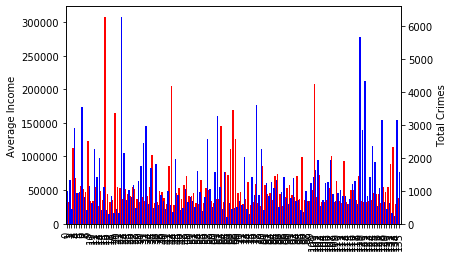

In [21]:
# df_bar.plot(kind='bar', figsize=(10, 6))
# plt.xlabel('Neighborhood') # add to x-label to the plot
# plt.ylabel('Average Income') # add y-label to the plot
# plt.title('Average income of Toronto neighborhoods') # add title to the plot
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.6

df['Average Income'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
df['Total Crimes'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Average Income')
ax2.set_ylabel('Total Crimes')

plt.show()

### Modelling

#### Clustering Neighborhoods

##### One hot encoding and frequency of venues

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beach Bar,...,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(136, 290)

In [24]:
toronto_grouped.head()

,Neighborhood,Zoo,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,...,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt North,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034483,0.0,0.0,0.0,0.034483,0.000000,0.0
1,Agincourt South-Malvern West,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,Alderwood,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,Annex,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,Banbury-Don Mills,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0


##### Most common venues

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Coffee Shop,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Bakery,Taco Place,Movie Theater,Juice Bar,Beer Store,Sporting Goods Shop
1,Agincourt South-Malvern West,Chinese Restaurant,Cantonese Restaurant,Restaurant,Park,Noodle House,Mediterranean Restaurant,Shopping Mall,Malay Restaurant,Breakfast Spot,Seafood Restaurant
2,Alderwood,Gas Station,Pharmacy,Convenience Store,Pizza Place,Park,Skating Rink,Gym,Storage Facility,Sandwich Place,Coffee Shop
3,Annex,Grocery Store,Beer Bar,Japanese Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Tea Room,Jewelry Store,Gift Shop
4,Banbury-Don Mills,Japanese Restaurant,Café,Coffee Shop,Restaurant,Gourmet Shop,Bakery,Bar,Supermarket,Movie Theater,Chocolate Shop


##### Add normalized crime and demographic data to the dataset

In [26]:
# Convert string values to float
df['Density'] = pd.to_numeric(df['Density'], errors='coerce')
df['Average Income'] = pd.to_numeric(df['Average Income'], errors='coerce')

# Min/Max-normalize
df["Total Crimes"] = (df["Total Crimes"]-df["Total Crimes"].min()) / (df["Total Crimes"].max()-df["Total Crimes"].min())
df["Density"] = (df["Density"]-df["Density"].min()) / (df["Density"].max()-df["Density"].min())
df["Average Income"] = (df["Average Income"]-df["Average Income"].min()) / (df["Average Income"].max()-df["Average Income"].min())

df.head()


,Neighborhood,Total Crimes,Density,Average Income,Latitude,Longitude
0,Agincourt North,0.133432,0.131294,0.015690,43.809299,-79.267067
1,Agincourt South-Malvern West,0.186313,0.090620,0.020693,43.787350,-79.269409
2,Alderwood,0.043713,0.063398,0.077016,43.604961,-79.541161
3,Annex,0.444499,0.446419,0.307697,43.669361,-79.402802
4,Banbury-Don Mills,0.121971,0.078849,0.148102,43.740410,-79.348518


In [27]:
k_df = toronto_grouped
k_df = k_df.join(df.set_index('Neighborhood'), on='Neighborhood')
# drop NaN columns
k_df = k_df.dropna().reset_index(drop=True)
k_df.drop(["Longitude", "Latitude"], axis=1, inplace=True)
k_df.head()


,Neighborhood,Zoo,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,...,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Total Crimes,Density,Average Income
0,Agincourt North,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034483,0.0,0.0,0.0,0.034483,0.000000,0.0,0.133432,0.131294,0.015690
1,Agincourt South-Malvern West,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.186313,0.090620,0.020693
2,Alderwood,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043713,0.063398,0.077016
3,Annex,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.444499,0.446419,0.307697
4,Banbury-Don Mills,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.121971,0.078849,0.148102


##### Elbow method for clustering

/home/nando/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


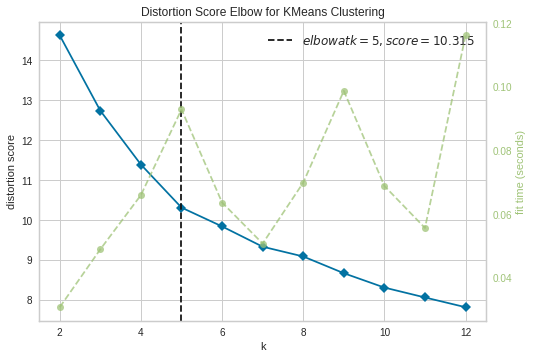

In [28]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X = k_df.drop('Neighborhood', axis = 1)
model = KMeans()
vis = KElbowVisualizer(model, k=(2,13))
vis.fit(X)
vis.show()

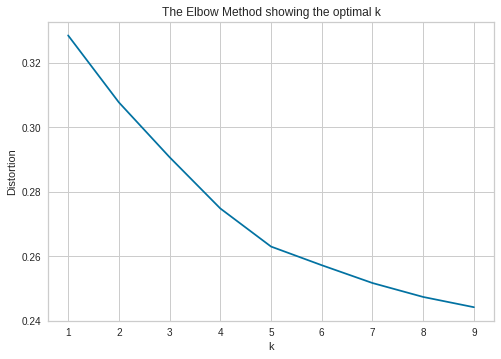

In [29]:
# elbow manually

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
# create new plot and data
plt.plot()
# colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(max_iter=1000, n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
X.head()

,Zoo,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beach Bar,...,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Total Crimes,Density,Average Income
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.034483,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034483,0.0,0.0,0.0,0.034483,0.000000,0.0,0.133432,0.131294,0.015690
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.186313,0.090620,0.020693
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043713,0.063398,0.077016
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.444499,0.446419,0.307697
4,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.121971,0.078849,0.148102


In [31]:
# elbow method lead to 5 as best number of clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
kmeans.labels_


array([1, 1, 1, 4, 1, 1, 3, 1, 1, 2, 1, 0, 1, 0, 4, 1, 2, 1, 1, 1, 2, 1,
       3, 0, 1, 1, 4, 4, 1, 1, 0, 4, 0, 4, 4, 2, 0, 1, 1, 1, 1, 4, 4, 2,
       0, 4, 1, 1, 4, 1, 1, 1, 1, 0, 1, 4, 1, 0, 1, 1, 1, 3, 1, 2, 1, 1,
       1, 2, 2, 2, 4, 1, 0, 1, 1, 1, 1, 3, 1, 0, 1, 4, 1, 1, 1, 4, 1, 1,
       1, 4, 1, 4, 1, 1, 4, 1, 2, 4, 1, 1, 4, 2, 0, 1, 1, 1, 4, 0, 2, 1,
       1, 1, 4, 1, 1, 1, 4, 1, 1, 3, 0, 0, 1, 1, 0, 4, 1, 1, 0, 1, 1, 4,
       4, 4, 0, 0], dtype=int32)

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
tdf = df
tdf = tdf.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tdf.head()

# todo: do not use normalized values, insert income... long lat

,Neighborhood,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,0.133432,0.131294,0.015690,43.809299,-79.267067,1,Coffee Shop,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Bakery,Taco Place,Movie Theater,Juice Bar,Beer Store,Sporting Goods Shop
1,Agincourt South-Malvern West,0.186313,0.090620,0.020693,43.787350,-79.269409,1,Chinese Restaurant,Cantonese Restaurant,Restaurant,Park,Noodle House,Mediterranean Restaurant,Shopping Mall,Malay Restaurant,Breakfast Spot,Seafood Restaurant
2,Alderwood,0.043713,0.063398,0.077016,43.604961,-79.541161,1,Gas Station,Pharmacy,Convenience Store,Pizza Place,Park,Skating Rink,Gym,Storage Facility,Sandwich Place,Coffee Shop
3,Annex,0.444499,0.446419,0.307697,43.669361,-79.402802,4,Grocery Store,Beer Bar,Japanese Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Tea Room,Jewelry Store,Gift Shop
4,Banbury-Don Mills,0.121971,0.078849,0.148102,43.740410,-79.348518,1,Japanese Restaurant,Café,Coffee Shop,Restaurant,Gourmet Shop,Bakery,Bar,Supermarket,Movie Theater,Chocolate Shop


In [33]:
tdf.columns

Index(['Neighborhood', 'Total Crimes', 'Density', 'Average Income', 'Latitude',
       'Longitude', 'Cluster', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

##### Visualisation of clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tdf['Latitude'], tdf['Longitude'], tdf['Neighborhood'], tdf['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examination of clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [35]:
tdf.columns

Index(['Neighborhood', 'Total Crimes', 'Density', 'Average Income', 'Latitude',
       'Longitude', 'Cluster', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [36]:
tdf.loc[tdf['Cluster'] == 0, tdf.columns[[1] + list(range(2, tdf.shape[1]))]]

,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,0.341192,0.135021,0.025768,43.759628,-79.257393,0,Pizza Place,Park,Bakery,Caribbean Restaurant,Optical Shop,Intersection,Dog Run,Grocery Store,Fast Food Restaurant,Tennis Court
13,0.296824,0.238229,0.000000,43.766361,-79.521500,0,Tennis Stadium,Pharmacy,Gym / Fitness Center,Pizza Place,Skating Rink,Shopping Mall,Liquor Store,Gas Station,Kitchen Supply Store,Grocery Store
23,0.322528,0.117797,0.036320,43.715988,-79.283699,0,Bakery,Diner,Bus Line,Coffee Shop,Bus Station,Intersection,Bus Stop,Beer Store,Sporting Goods Shop,Furniture / Home Store
30,0.255894,0.141156,0.020222,43.755329,-79.277458,0,Electronics Store,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Burger Joint,Asian Restaurant,Italian Restaurant,Gas Station,Brewery,Bowling Alley
32,0.455305,0.058944,0.029001,43.728920,-79.491364,0,Vietnamese Restaurant,New American Restaurant,Bank,Gym / Fitness Center,Falafel Restaurant,Coffee Shop,Burrito Place,Fast Food Restaurant,Turkish Restaurant,Sandwich Place
36,0.263752,0.273178,0.014339,43.739622,-79.232290,0,Fast Food Restaurant,Sandwich Place,Train Station,Hotel,Restaurant,Convenience Store,Indian Restaurant,Coffee Shop,Big Box Store,Falafel Restaurant
44,0.292731,0.219233,0.007074,43.746750,-79.515038,0,Vietnamese Restaurant,Plaza,Grocery Store,Park,Moving Target,Tea Room,Bank,Pizza Place,High School,Egyptian Restaurant
53,0.228716,0.024087,0.016814,43.760159,-79.558487,0,Empanada Restaurant,General Entertainment,Pizza Place,Electronics Store,Fast Food Restaurant,Skating Rink,Arts & Crafts Store,Farm,Farmers Market,Field
57,0.392272,0.075986,0.095021,43.636082,-79.542961,0,Fast Food Restaurant,Coffee Shop,Vietnamese Restaurant,Restaurant,Grocery Store,Fried Chicken Joint,Burger Joint,Thai Restaurant,Bank,Sushi Restaurant
72,0.299771,0.177604,0.012708,43.809769,-79.220840,0,Pharmacy,Grocery Store,Pizza Place,Park,Fried Chicken Joint,Fast Food Restaurant,Skating Rink,Sandwich Place,Salon / Barbershop,Bubble Tea Shop


#### Cluster 2

In [37]:
tdf.loc[tdf['Cluster'] == 1, tdf.columns[[1] + list(range(2, tdf.shape[1]))]]

,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0.133432,0.131294,0.015690,43.809299,-79.267067,1,Coffee Shop,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Bakery,Taco Place,Movie Theater,Juice Bar,Beer Store,Sporting Goods Shop
1,0.186313,0.090620,0.020693,43.787350,-79.269409,1,Chinese Restaurant,Cantonese Restaurant,Restaurant,Park,Noodle House,Mediterranean Restaurant,Shopping Mall,Malay Restaurant,Breakfast Spot,Seafood Restaurant
2,0.043713,0.063398,0.077016,43.604961,-79.541161,1,Gas Station,Pharmacy,Convenience Store,Pizza Place,Park,Skating Rink,Gym,Storage Facility,Sandwich Place,Coffee Shop
4,0.121971,0.078849,0.148102,43.740410,-79.348518,1,Japanese Restaurant,Café,Coffee Shop,Restaurant,Gourmet Shop,Bakery,Bar,Supermarket,Movie Theater,Chocolate Shop
5,0.124100,0.106208,0.070729,43.763779,-79.454773,1,Playground,Convenience Store,Baseball Field,Nightclub,Park,Sandwich Place,Furniture / Home Store,Breakfast Spot,Flower Shop,Flea Market
7,0.099050,0.143383,0.092355,43.777100,-79.379570,1,Park,Clothing Store,Pet Store,Trail,Flower Shop,Fish Market,Persian Restaurant,Breakfast Spot,Sporting Goods Shop,Liquor Store
8,0.038474,0.099982,0.075374,43.794849,-79.382202,1,Bank,Park,Japanese Restaurant,Music Store,Chinese Restaurant,Fast Food Restaurant,Café,Gas Station,Grocery Store,Shopping Mall
10,0.069090,0.116979,0.027799,43.693111,-79.478310,1,Furniture / Home Store,Grocery Store,Discount Store,Portuguese Restaurant,Fast Food Restaurant,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Auto Garage
12,0.199411,0.123841,0.100599,43.694721,-79.264603,1,Park,College Stadium,Gym Pool,Thai Restaurant,General Entertainment,Convenience Store,Diner,Restaurant,Gym,Skating Rink
15,0.151277,0.306808,0.031129,43.698521,-79.451248,1,Coffee Shop,Caribbean Restaurant,Sandwich Place,Bank,Furniture / Home Store,Portuguese Restaurant,Bike Shop,Beer Store,Fast Food Restaurant,Gas Station


#### Cluster 3

In [38]:
tdf.loc[tdf['Cluster'] == 2, tdf.columns[[1] + list(range(2, tdf.shape[1]))]]

,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,0.154224,0.144019,0.344258,43.730659,-79.424500,2,Coffee Shop,Bagel Shop,Italian Restaurant,Bakery,Liquor Store,Chinese Restaurant,Restaurant,Fast Food Restaurant,Bridal Shop,Juice Bar
16,0.037164,0.000000,1.000000,43.727322,-79.380814,2,Café,Coffee Shop,Trail,Bus Line,Deli / Bodega,Food Court,Lawyer,Juice Bar,Bookstore,Restaurant
20,0.043222,0.211007,0.493077,43.680779,-79.409492,2,Café,Middle Eastern Restaurant,Ice Cream Shop,History Museum,Tea Room,Jewish Restaurant,Gastropub,Burger Joint,French Restaurant,Mexican Restaurant
35,0.045842,0.081803,0.267930,43.669910,-79.521263,2,Park,Camera Store,Spa,Japanese Restaurant,Grocery Store,Liquor Store,Garden,Bus Line,Shopping Mall,Skating Rink
43,0.027341,0.151791,0.633045,43.694309,-79.416100,2,Café,Trail,Jewelry Store,Liquor Store,Sushi Restaurant,Coffee Shop,Juice Bar,Bookstore,Bank,Bagel Shop
63,0.042731,0.116024,0.420724,43.654331,-79.511124,2,Coffee Shop,French Restaurant,Dessert Shop,Italian Restaurant,Burger Joint,Pizza Place,Tapas Restaurant,Sushi Restaurant,Supermarket,Gastropub
67,0.041257,0.243910,0.304023,43.728298,-79.406418,2,Sushi Restaurant,Bakery,Burger Joint,Coffee Shop,Italian Restaurant,Tea Room,Toy / Game Store,Bubble Tea Shop,Sandwich Place,Garden
68,0.045023,0.165652,0.507813,43.718529,-79.405739,2,Coffee Shop,Sporting Goods Shop,Pizza Place,Café,Diner,Spa,Skating Rink,Salon / Barbershop,Chinese Restaurant,Restaurant
69,0.051408,0.116161,0.353077,43.700710,-79.367577,2,Sporting Goods Shop,Coffee Shop,Bakery,Grocery Store,Fish & Chips Shop,Trail,Supermarket,Sushi Restaurant,Restaurant,Thai Restaurant
96,0.027832,0.049900,0.259080,43.665310,-79.545609,2,Park,Playground,Athletics & Sports,Pizza Place,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 4

In [39]:
tdf.loc[tdf['Cluster'] == 3, tdf.columns[[1] + list(range(2, tdf.shape[1]))]]

,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,0.551899,0.593392,0.108279,43.657711,-79.386177,3,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Tea Room,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Gastropub,Restaurant,Bar
22,1.000000,1.000000,0.097844,43.660240,-79.378677,3,Coffee Shop,Pizza Place,Ramen Restaurant,Yoga Studio,Burrito Place,Juice Bar,Gay Bar,Gastropub,Supermarket,Steakhouse
61,0.502620,0.489275,0.040540,43.653309,-79.396339,3,Café,Coffee Shop,Mexican Restaurant,Art Gallery,Noodle House,Sandwich Place,Record Shop,Cheese Shop,Cocktail Bar,Bar
77,0.559267,0.623205,0.116750,43.655022,-79.367996,3,Coffee Shop,Café,Italian Restaurant,Breakfast Spot,Furniture / Home Store,Liquor Store,Gastropub,German Restaurant,Farmers Market,Restaurant
119,0.897348,0.359162,0.158183,43.641576,-79.377868,3,Hotel,Park,Plaza,Coffee Shop,Liquor Store,Beer Bar,Supermarket,Steakhouse,Lake,Sports Bar


#### Cluster 5

In [40]:
tdf.loc[tdf['Cluster'] == 4, tdf.columns[[1] + list(range(2, tdf.shape[1]))]]


,Total Crimes,Density,Average Income,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,0.444499,0.446419,0.307697,43.669361,-79.402802,4,Grocery Store,Beer Bar,Japanese Restaurant,Café,Bakery,Thai Restaurant,Italian Restaurant,Tea Room,Jewelry Store,Gift Shop
14,0.037983,0.322396,0.079859,43.676503,-79.337374,4,Café,Park,American Restaurant,Pizza Place,Gastropub,Hostel,Caribbean Restaurant,Bookstore,Brewery,Burger Joint
26,0.102325,0.292583,0.055769,43.676991,-79.450378,4,Italian Restaurant,Breakfast Spot,Sushi Restaurant,Coffee Shop,Café,Brazilian Restaurant,Mediterranean Restaurant,Bank,Bakery,Fish Market
27,0.163392,0.341483,0.103666,43.648689,-79.385437,4,Café,Hotel,Theater,Concert Hall,Coffee Shop,Steakhouse,Gym / Fitness Center,Sushi Restaurant,Restaurant,Speakeasy
31,0.369515,0.398973,0.048759,43.666039,-79.436867,4,Café,Bakery,Bar,Coffee Shop,Italian Restaurant,Beer Bar,Music Store,Beer Store,Supermarket,Gym / Fitness Center
33,0.066961,0.340847,0.051766,43.655140,-79.437309,4,Café,Bar,Italian Restaurant,Restaurant,Bakery,Park,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Sandwich Place
34,0.245252,0.318033,0.100471,43.684151,-79.299110,4,Coffee Shop,Sushi Restaurant,Paper / Office Supplies Store,Gas Station,Thai Restaurant,Bakery,Pub,Gastropub,Breakfast Spot,BBQ Joint
41,0.132286,0.362934,0.009450,43.716309,-79.331711,4,Japanese Restaurant,Science Museum,Middle Eastern Restaurant,Sandwich Place,Gym,Grocery Store,Skating Rink,Fast Food Restaurant,Falafel Restaurant,Caribbean Restaurant
42,0.061395,0.318760,0.209594,43.705219,-79.427452,4,Coffee Shop,Pizza Place,Pharmacy,Bank,Frozen Yogurt Shop,Grocery Store,Gastropub,Sushi Restaurant,Gift Shop,Skating Rink
45,0.113294,0.342756,0.071686,43.671951,-79.323433,4,Café,Indian Restaurant,Brewery,Park,Pizza Place,Farmers Market,Fish & Chips Shop,Liquor Store,Bar,Grocery Store
